<h1><b>Работа с гипотезами</b></h1>

<h2><b>1 | <span style="color: #10a3d7">INTRODUCTION</span></b></h2>


<h3><b><span style="color: #10a3d7">⡱⡷</span> Об эксперементе</b></h3>

- Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. 
- Эксперимент проходил **с 2023-01-01 по 2023-01-07** (7 дней) включительно. Для эксперимента были **задействованы 2 и 1 группы** 
- В **группе 2** был использован один из новых алгоритмов рекомендации постов, **группа 1 использовалась в качестве контроля**. 

<h3><b><span style="color: #10a3d7">⡱⡷</span> Гипотиза</b></h3>

> Основная гипотеза заключается в том, что новый алгоритм во **2-й группе** приведет **к увеличению CTR.**

<h3><b><span style="color: #10a3d7">⡱⡷</span> Наша задача</b></h3>

Ваша задача — **проанализировать данные АB-теста**

**Выбрать метод** анализа и **сравнить CTR** в двух группах, мы разбирали:
   
* **`t-тест`**
* **`Пуассоновский бутстреп`**
* **`тест Манна-Уитни`**
* **`t-тест на сглаженном ctr (α=5)`**
* **`t-тест и тест Манна-Уитни поверх бакетного преобразования`**

- Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
- Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
- Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит

<h2><b>2 | <span style="color: #10a3d7">DATA EXPORT</span></b></h2>


- Данные с БД содержат 4 колонки; **`exp_group`** (группа в эксперементе) **`user_id`** (пользователь) **`likes`** (количество поставленных лайков) **`views`** (количество просмотров)

<h3><b><span style="color: #10a3d7">⡱⡷</span> Данные в БД</b></h3>

Данные эксперемента загружены в БД, и нам потребуется выгрузить их и провести свои анализ 

```
      exp_group    user_id    likes    views        ctr
--  -----------  ---------  -------  -------  ---------
 0            1     109963        3       15  0.2
 1            1      26117       32      141  0.22695
 2            1     138232       18       73  0.246575
 3            1      26295       33      122  0.270492
 4            1      18392        7       32  0.21875
 5            2     131473       14      134  0.104478
 6            2      23985        7       87  0.0804598
 7            2      24523       11      101  0.108911
 8            2      32420       26      128  0.203125
 9            2      24239       40       90  0.444444
```

<br>

<h3><b><span style="color: #10a3d7">⡱⡷</span> Выгрузка из БД</b></h3>

Выгрузим данные из БД

```python
query = '''
select exp_group, 
    user_id, 
    sum(action = 'like') likes,
    sum(action = 'view') views,
    likes/views ctr
from {db}.feed_actions 
where toDate(time) between '2023-01-01' and '2023-01-07'
    and exp_group in (1,2)
group by exp_group, user_id 
'''

df = ph.read_clickhouse(query, connection = connection)
```


Начнем с выгрузкой данных и подгрузка в наш ноутбук

- Определим схему данных и посмотрим на нее после загрузки чтобы проверить типы колонок
- Так выгрузим несколько строк из нашего датасета

In [220]:
from scipy import stats
import pandas as pd 
import numpy as np
import seaborn as sns;
sns.set_style('whitegrid')

In [34]:
dtypes = {'exp_group':int, 
          'user_id':int, 
          'likes':int, 
          'views':int}

df = pd.read_csv('ctr_data.csv',dtype=dtypes)

In [35]:
df.head(5)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


<h2><b>3 | <span style="color: #10a3d7">DESCRIPTIVE STATISTICS</span></b></h2>

Разделим данные на две выборки, тестовая и контрольные подвыборки, после чего сравним описательную статистику

- **`Контрольная`** : `exp_group = 1`
- **`Тестовая`** : `exp_group = 2`

In [36]:
df.groupby('exp_group')['ctr'].describe().T

exp_group,1,2
count,10079.000000,9952.000000
mean,0.215605,0.214419
std,0.084160,0.144180
min,0.000000,0.000000
25%,0.160097,0.095238
50%,0.203125,0.142857
75%,0.257654,0.325000
max,0.722222,0.923077


In [37]:
c = df[df['exp_group']==1]  # Контрольная группа
t = df[df['exp_group']==2]  # Тестовая группа (новый алгоритм)

<h2><b>4 | <span style="color: #10a3d7">UNIVARIATE STATISTICS</span></b></h2>

Посмотрим на расспределение, одномерное для облих выборок

- Можем видить что одномерное расспределение у обоих выборок очень разное
- Для **`контролькой`** (1) группы, расспределение похоже на **нормальное расспределение с небольшым перекосом влево**
- А вот распределение во второй **`тестовой`** (2) группе уже получилось с **явной бимодальность**

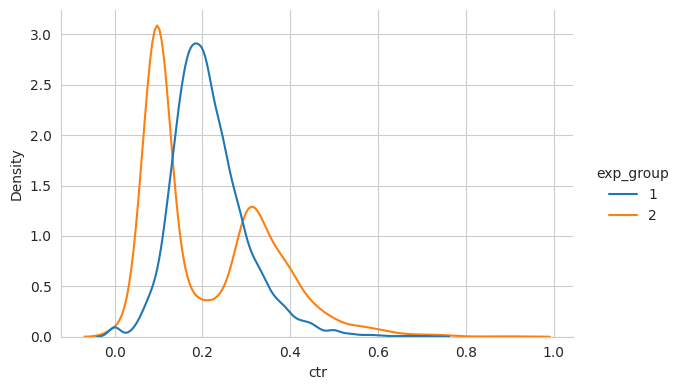

In [223]:
sns.displot(data=df, 
            x='ctr',
            hue='exp_group',
            kind='kde',
            palette="tab10",
            height=4,aspect=1.5)

- Такое изменение в **`ctr`** возможно что связанно с **рассхождением мнением о новом изменении**, кому то понравилось, а кому то нет, и тут видно что пик у левой выше чем у контролькой группы
- Так же **`t-test`** нельзя применять на таких расспределении, нужен другой способ справнения эффекта кового функционала

<h2><b>5 | <span style="color: #10a3d7">STATISTICAL TESTING</span></b></h2>


<h3><b><span style="color: #10a3d7">⡱⡷</span> Тест Стьюдента</b></h3>

> * $H_0$ - средние значения **CTR в контрольной** и экспериментальной группaх равны.  
> * $H_1$ - средние значения **CTR в тестовой группе выше**, чем в контрольной.

- Не может отвергнуть нулевую гипотизу, нет доказательств того, что среднее значение c.ctr меньше, чем среднее значение t.ctr.

In [39]:
stats.ttest_ind(c.ctr,
                t.ctr,
                equal_var=False,
                alternative='less').pvalue 

np.float64(0.7609688434562429)

**Обратная алтернативная гипотиза Стьюдента**

Проверим обратную альтернативную гипотезу:  
> * $H_0$ - средние значения **CTR в контрольной** и экспериментальной группaх равны.  
> * $H_1$  - средние значения **CTR в тестовой группе ниже**, чем в контрольной.

- Не может отвергнуть нулевую гипотизу, нет доказательств того, что среднее значение c.ctr больше, чем среднее значение t.ctr.

In [40]:
stats.ttest_ind(c.ctr,
                t.ctr,
                equal_var=False,
                alternative='greater').pvalue 

np.float64(0.23903115654375706)

<h3><b><span style="color: #10a3d7">⡱⡷</span> Тест Манна-Уитни</b></h3>

**Составим гипотизы**

> - **$H_0$** - $P(X > Y) = P(Y > X)$ означает, что **случайные величины $X$ и $Y$ имеют одинаковое распределение**
> - **$H_1$** - $P(X > Y) > P(Y > X)$ означает, что вероятность $X$ быть больше $Y$ больше, чем вероятность $Y$ быть больше $X$ ('greater')

Таким образом, тест Манна-Уитни проверяет, есть ли статистически значимая разница в расположении распределений двух независимых выборок $X$ и $Y$, без предположения о нормальности данных. 

| `alternative` | Альтернативная гипотеза H1                           | Что это означает                                            |
| ------------- | ---------------------------------------------------- | ----------------------------------------------------------- |
| `'less'`      | P(X<Y)>P(X>Y)                                        | Первая выборка имеет меньшие значения, чем вторая           |
| `'greater'`   | P(X>Y)>P(X<Y)                                        | Первая выборка имеет большие значения, чем вторая           |
| `'two-sided'` | Распределения различаются (без направления различия) | Есть отличие в двух выборках, но неизвестно в какую сторону |


In [41]:
# random sample from c > t
stats.mannwhitneyu(c.ctr,
                   t.ctr,
                   alternative='greater').pvalue

np.float64(3.0188242308889518e-56)

**Обратная алтернативная гипотиза Манна-Уитни**

In [42]:
stats.mannwhitneyu(c.ctr,
                   t.ctr,
                   alternative='less').pvalue

np.float64(1.0)

<h3><b><span style="color: #10a3d7">⡱⡷</span> Итоги статистических тестов</b></h3>

Подведем итоги двух статистических тестов

- **Тест Стьюдента не прокрасился из-за заложенного в t статистику сравнения среднего выборок**, а они в двух выборках практически идентичны.  
- А вот **тест Манна-Уитни** учитывает расположение элементов выборок относительно друг друга (однородность распределений), а не значения элементов.
- Поэтому он и не зависит от средних выборок и **показал наличие статистически значимых различий в выборках**.
- Что касается гипотезы, то подтверждается **`обратная альтернативная`** гипотеза:
   - Вероятность получения случайного числа CTR из контрольной группы большего по значению, чем случайного числа CTR из тестовой группы выше, чем вероятность получения случайного числа CTR из контрольной группы меньшего по значению, чем случайного числа CTR из тестовой группы.



<h2><b>6 | <span style="color: #10a3d7">SMOOTHED CTR METRIC</span></b></h2>

<h3><b><span style="color: #10a3d7">⡱⡷</span> Количество просмотров</b></h3>

Проведем еще один тест

Проверим качество **`CTR`** в выборках **по количеству просмотров** на пользователя

In [43]:
df.groupby('exp_group')['views'].describe().T

exp_group,1,2
count,10079.000000,9952.000000
mean,66.299831,66.148513
std,45.043411,45.151210
min,2.000000,1.000000
25%,32.000000,32.000000
50%,56.000000,56.000000
75%,90.000000,91.000000
max,311.000000,321.000000


In [178]:
# sns.set_palette("bright")

<Axes: xlabel='views', ylabel='Count'>

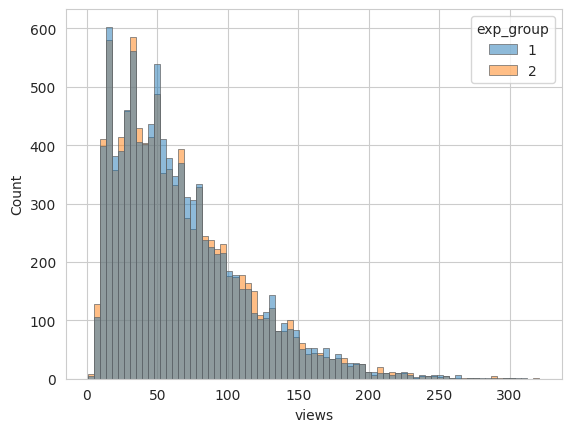

In [227]:
sns.histplot(
    df,
    x="views", 
    hue="exp_group",
    edgecolor=".4",
    linewidth=.5,
    palette="tab10"
)

Возникает важный вопрос, достатосно ли это количество просмотров

<h3><b><span style="color: #10a3d7">⡱⡷</span> Формируем колонку с сглаженным CTR</b></h3>

Количество просмотров на пользователя

- **`CTR`** в обеих группах сильно зашумлен данными от пользователей с низким количеством просмотров. 
- **В двух группах 75-й процентиль это ~ 90 просмотров на юзера!**.
Такого количества просмотров недостаточно для точной оценки CTR.
- **Применение процедуры сглаживания Лапласа к метрике CTR обосновано**

<br>

<center>$smoothed CTR_u = \dfrac{clicks_u+\alpha*globalCTR}{views_u + \alpha}$</center>


Где $\alpha$ — гиперпараметр.   

Идея проста: 

- Когда просмотров много, сглаженный CTR почти равен CTR пользователя. 
- Когда просмотров мало, сглаженный CTR почти равен общегрупповому CTR.

Иначе говоря, если у пользователя **много просмотров**, мы можем быть уверены, что **клики / просмотры — хорошая оценка его CTR**, 
а когда у пользователя просмотров мало, мы устанавливаем в качестве оценки общегрупповой CTR

In [45]:
gctr1 = c['likes'].sum()/c['views'].sum()
gctr2 = t['likes'].sum()/t['views'].sum()

In [46]:
def get_smooth(x):
    if x.exp_group == 1:
        return (x.likes + 5 * gctr1) / (x.views + 5)
    else:
        return (x.likes + 5 * gctr2) / (x.views + 5)    

df['smooth_ctr'] = df.apply(get_smooth,axis=1)

In [47]:
c = df.query('exp_group == 1') # control 
t = df.query('exp_group == 2') # test 

<h3><b><span style="color: #10a3d7">⡱⡷</span> Проведем t-тест Стьюдента на сглаженных CTR</b></h3>

* $H_0$ - средние значения CTR в контрольной и экспериментальной группaх **равны**  
* $H_1$ - **средние значения CTR в тестовой группе выше**, чем в контрольной.

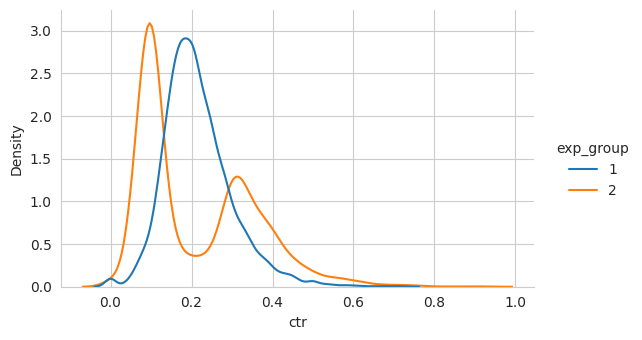

In [228]:
sns.displot(data=df,
            x='ctr',
            hue='exp_group',
            kind='kde', 
            height=3.5, 
            aspect=1.6,
            palette="tab10")

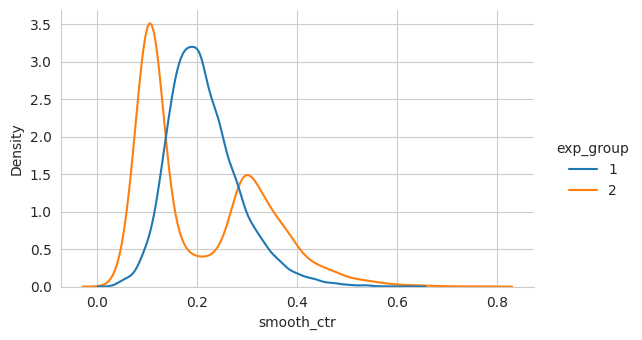

In [229]:
sns.displot(data=df, 
            x='smooth_ctr',
            hue='exp_group',
            kind='kde', 
            height=3.5,
            aspect=1.6,
            palette="tab10")

In [213]:
# t-test independent
stats.ttest_ind(
                c.smooth_ctr,
                t.smooth_ctr,
                equal_var=False,
                alternative='less')

TtestResult(statistic=np.float64(2.2841320431616983), pvalue=np.float64(0.9888115092220721), df=np.float64(15791.866890424124))

Проверим обратную альтернативную гипотезу:  
* $H_0$  - средние значения CTR в контрольной и экспериментальной группaх равны.  
* $H_1$  - средние значения CTR в тестовой группе ниже, чем в контрольной.  

In [51]:
# can't reject 
stats.ttest_ind(
                c.smooth_ctr,
                t.smooth_ctr,
                equal_var=False,
                alternative='greater')

TtestResult(statistic=np.float64(2.2841320431616983), pvalue=np.float64(0.011188490777927938), df=np.float64(15791.866890424124))

Отлично, тест прокрасился! pval < 0.05

In [52]:
# difference on means bw groups before after 
mean_ctr_before = df[df['exp_group']==1].ctr.mean()-df[df['exp_group']==2].ctr.mean()
mean_ctr_after =  df[df['exp_group']==1].smooth_ctr.mean()-df[df['exp_group']==2].smooth_ctr.mean()

print(f'before: {round(mean_ctr_before,3)}, after: {round(mean_ctr_after,3)}')

before: 0.001, after: 0.003


In [53]:
round(mean_ctr_after / mean_ctr_before,3)

np.float64(2.772)

In [54]:
print(c.ctr.std() / c.smooth_ctr.std())

1.1792320742547526


- **Разница средних значений CTR в тестовой выборке после сглаживания Лапласа увеличилась в 2.7 раз!**
- После сглаживания Лапласа стандартное отклонение CTR в обеих выборках уменьшилось на ~ 17%
- Из-за увеличения разности средних в три раза и уменьшения стандартного отклонения уменьшились оценки дисперсии. Это и дало увлечение t критерия в три раза, что и снизило p-value.

**Вывод: применение сглаживания Лапласа для метрики CTR позволило увеличить чувствительность t-критерия и обнаружить статистически значимую разницу в группах.**   

Однако теоретической гарантии, что его направленность совпадает с направленностью общего количества лайков, нет и применять такой метод следует только на свой страх и риск.

<h3><b><span style="color: #10a3d7">⡱⡷</span> Проведем Тест Манна-Уитни на сглаженных CTR</b></h3>

In [55]:
# alternatie: random sample from control larger than random sample from test
stats.mannwhitneyu(c.smooth_ctr,
                   t.smooth_ctr,
                   alternative='greater').pvalue

np.float64(8.081982057135114e-62)

In [56]:
# alternative: random sample from control lower than random sample from control 
stats.mannwhitneyu(c.smooth_ctr,
                   t.smooth_ctr,
                   alternative='less').pvalue

np.float64(1.0)

- Как и ожидалось, тест Манна-Уитни показал наличие статистически значимых различий в выборках сглаженных **`CTR`** 
- Тест учитывает расположение элементов выборок относительно друг друга (однородность распределений), а не значения элементов.
- Поэтому **он и не зависит от изменившихся после сглаживания средних выборок** и **на чувствительность теста такое преобразование практически не повлияло.**

<h2><b>7 | <span style="color: #10a3d7">NON-PARAMETRIC BOOTSTRAP</span></b></h2>

Создалим две псевдовыборки

- Для сравнения среднего **`CTR`** в первой(контрольной) и второй(тестовых) группах, применим **непараметрический бутстреп**
- Будем **рандомно генировать псевдовыборки** из **`CTR`** групп 1 и 2 длиной этих групп и каждую итерацию считать среднее по этим CTR и записывать их в список, на основе которых потом проведем анализ.
- Построим **`kde`** получившихся распределений средних **`CTR`** из этих 100/1000 псевдовыборок из тестовой и контрольной групп.
- Визуально заметно, как **средние значения CTR** в псевдовыборках из **контрольной группы больше**

In [57]:
import numpy as np

def boostrap_sample_mean(df,n_samples=10):

    lst_means = []
    for i in range(n_samples):
        samples = np.random.choice(df['ctr'], 
                                   size=len(df), 
                                   replace=True)
        lst_means.append(np.mean(samples))

    return lst_means

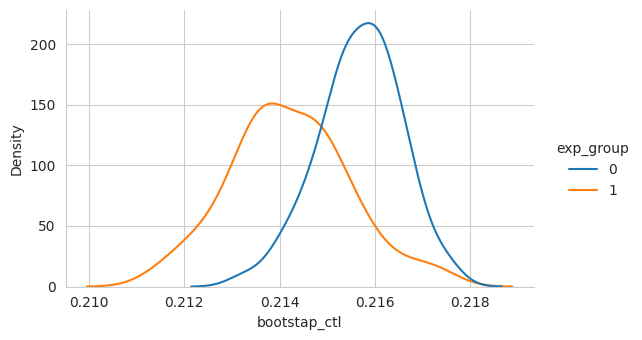

In [230]:
cb = boostrap_sample_mean(c,100)
tb = boostrap_sample_mean(t,100)
cbs = pd.Series(cb,name='bootstap_ctl').to_frame()
tbs = pd.Series(tb,name='bootstap_ctl').to_frame()
cbs['exp_group'] = 0
tbs['exp_group'] = 1
m = pd.concat([cbs,tbs])
sns.displot(data=m, 
            x='bootstap_ctl',
            hue='exp_group',
            kind='kde', 
            height=3.5, 
            aspect=1.6,
            palette="tab10")

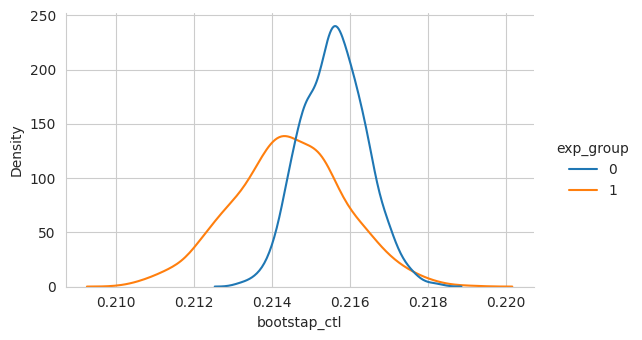

In [231]:
cb = boostrap_sample_mean(c,1000)
tb = boostrap_sample_mean(t,1000)
cbs = pd.Series(cb,name='bootstap_ctl').to_frame()
tbs = pd.Series(tb,name='bootstap_ctl').to_frame()
cbs['exp_group'] = 0
tbs['exp_group'] = 1
m = pd.concat([cbs,tbs])
sns.displot(data=m, 
            x='bootstap_ctl',
            hue='exp_group',
            kind='kde', 
            height=3.5,
            aspect=1.6,
            palette="tab10")

Проведем тесты параметрическим методом с использованием **t-критерия Стьюдента** и его непараметрическим аналогом - W критерием Уилкоксона в тесте Манна-Уитни .

* $H_0$ - средние значения **`CTR`** в контрольной и экспериментальной группaх равны.  
* $H_1$ - средние значения **`CTR`** в контрольной группе выше, чем в тестовой.

In [60]:
cbst = m.query('exp_group == 0')
tbst = m.query('exp_group == 1')

In [61]:
'''

In essence, this code tests whether the average of  cbst.bootstap_ctl  is significantly greater than the average of tbst.bootstap_ctl , without assuming equal variances between the groups. 

The output  pvalue  tells you the significance level of that test: a small p-value (e.g., less than 0.05) suggests strong evidence that  cbst.bootstap_ctl  has a greater mean than  tbst.bootstap_ctl .

In other words, there is very strong statistical evidence to reject the null hypothesis, you reject the null hypothesis in favor of the alternative hypothesis.

'''

stats.ttest_ind(cbst.bootstap_ctl, 
                tbst.bootstap_ctl, 
                equal_var=False,
                alternative='greater').pvalue

np.float64(1.9380769874716835e-103)

- Принимаем **односторонюю гипотезу** о большем значении среднего в распредлении средних **`CTR`** пседовыборок из группы 1, т.е. контрольной, отвергая нулевую гипотизу в сторону альтернативной 
- Новый ML алгоритм во 2 группе привел к снижению **`CTR`**

In [62]:
# random sample from control greater than random sample from test
stats.mannwhitneyu(cbst.bootstap_ctl,
                   tbst.bootstap_ctl, 
                   alternative='greater').pvalue

np.float64(1.9816531341532074e-96)

<h3><b><span style="color: #10a3d7">⡱⡷</span> Вывод</b></h3>

Принимаем гипотезу о том:
- Вероятность получения **случайного числа среднего CTR из псевдовыборки контрольной группы большего по значению**, чем случайного числа среднего CTR из псевдовыборки тестовой группы **выше**, чем вероятность получения случайного числа среденего CTR из псевдовыборки контрольной группы меньшего по значению, чем случайного числа среднего CTR из псевдовыборки тестовой группы.

<h3><b><span style="color: #10a3d7">⡱⡷</span> Недостаток бутстреп</b></h3>

К недостатку бутсрепа можно отнести 
- использование малореалистичного предположения о независимости перевыборок 
- и значительные вычислительные затраты при их многократном построении.

<h2><b>8 | <span style="color: #10a3d7">POISSON BOOTSTRAP</span></b></h2>

Разновидность классического бутстрапа (bootstrap), метода статистического ресемплинга. В классическом бутстрапе для создания каждой новой выборки случайным образом выбираются с возвратом наблюдения из исходной выборки, при этом размер каждой бутстрап-выборки равен исходному объему. В Poisson bootstrap подход отличается по способу выбора:

- Каждому наблюдению в исходной выборке **присваивается число появлений (веса)** в бутстрап-выборке, которое выбирается из пуассоновского распределения с параметром 1
- Количество раз, которое каждое наблюдение попадает в бутстрап-выборку, является **независимой случайной величиной**.
- Размер самой бутстрап-выборки становится случайной величиной, с ожидаемым значением равным исходному объему, но фактически может отличаться от него.
- В классическом бутстрапе веса следуют мультиномальному распределению с суммой весов фиксированной и равной размеру выборки, а в пуассоновском весовые переменные независимы.


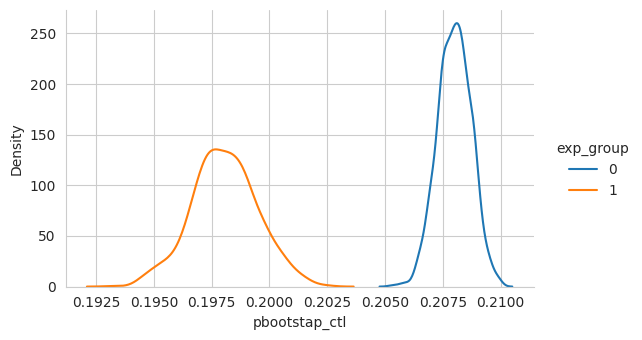

In [232]:
def pboostrap_sample_mean(df,n_samples):
    poisson_samples = stats.poisson(1).rvs((n_samples, len(df.likes.values))).astype(np.int64) # (n_samples,n_likes)
    return (poisson_samples*df.likes.values).sum(axis=1)/(poisson_samples*df.views.values).sum(axis=1)

cb = pboostrap_sample_mean(c,1000)
tb = pboostrap_sample_mean(t,1000)
cbs = pd.Series(cb,name='pbootstap_ctl').to_frame()
tbs = pd.Series(tb,name='pbootstap_ctl').to_frame()
cbs['exp_group'] = 0
tbs['exp_group'] = 1
m = pd.concat([cbs,tbs])
sns.displot(data=m, 
            x='pbootstap_ctl',
            hue='exp_group',
            kind='kde', 
            height=3.5, 
            aspect=1.6,
            palette="tab10")


- Очевидно, что глобальные **`CTR`** в **псевдовыборках из контрольной группы больше**, чем в тествой, так как графики их распределений даже не пересекаются.
- Можно утверждать, что новый ML алгоритм (группа 2) в тестовоaй группе 2 (красная на графике выше) **приводит к снижению глобального CTR**
   
**Проведем тест параметрическим методом с использованием t-критерия Стьюдента.**

In [64]:
stats.ttest_ind(cb, 
                tb, 
                equal_var=False,
                alternative='greater')

TtestResult(statistic=np.float64(200.72534507069847), pvalue=np.float64(0.0), df=np.float64(1505.7451048818073))

- p-value = 0, что очевидно меньше уровня значимости в 0.05. 
- Следовательно можем принять гипотезу, что среднее значение глобальных CTR псевдовыборок контрольной группы больше, чем среднее значение глобальных CTR псевдовыборок тестовой группы.  
- Новый ML алгоритм во 2 группе привел к снижению CTR.

<h2><b>9 | <span style="color: #10a3d7">BUCKETISED STATISTICAL TESTS</span></b></h2>
   
Порядок действии:

- Необходимо разбить пользователей на n «корзинок» («бакетов»).
- Нужно гарантировать, что каждый пользователь попадет только в один бакет и пользователи по бакетам будут распределены равномерно. 
- Это можно гарантировать с помощью того же хеширования с солью. Каждый бакет теперь становится как бы «метапользователем», участвующим в эксперименте.
- И внутри такого «метапользователя» показатель нужно как-то агрегировать.
- Будем вычеслять среднее CTR по бакету.   

Разделим контрольные и тестовые группы по 50 бакетов и считаем в каждом бакете среднее. 

В итоге на выходе получим две выборки из 50 значений средних CTR по этим «метапользователям». 

Это как будто мы сделали бутстреп, но только не сгенерировав псевдовыборку, а откусив правильным образом кусок из имеющейся.

Разделим две группы пользователей на 50 бакетов прямо в ClickHouse с помощью функции хэширования **xxHash64**:

```sql
query1 = """
select 
    exp_group, 
    bucket,
    sum(likes)/sum(views) as bucket_ctr
from 
    (
    select 
        exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    from {db}.feed_actions 
    where toDate(time) between '2023-01-01' and '2023-01-07'
          and exp_group in (1,2)
    group by exp_group, bucket, user_id
    )
group by exp_group, bucket
"""

df1 = ph.read_clickhouse(query1, 
                        connection = connection)
```

Выгрузив данные, загружаем их из локального фаила

In [65]:
import os; os.listdir()
import pandas as pd

bu = pd.read_csv('bucket_ctr.csv',sep=',',index_col=[0])
bu.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271


In [66]:
# делим на группы
bc = bu[bu['exp_group']==1]
bt = bu[bu['exp_group']==2]

In [67]:
round(stats.ttest_ind(bc.bucket_ctr,
                bt.bucket_ctr,
                equal_var=False, 
                alternative='less').pvalue,5)

np.float64(1.0)

- Такой высокий **p-value** говорит о большом противоречии с алтереативной гипотезы; значении сренего одинаковы либо среднее из контрольной группы больше
- Нет статистического обоснования того что значение из контролькой группы меньше, опровергаем нулевую гипотизу

In [68]:
round(stats.ttest_ind(bc.bucket_ctr,
                bt.bucket_ctr,
                equal_var=False, 
                alternative='greater').pvalue,5)

np.float64(0.0)

- Отвергаем нулевую гипотизу в пользу альтернативной
- Этот подход так же говорит о том что значение среднего больше в контрольной группе 

In [69]:
stats.mannwhitneyu(bc.bucket_ctr, 
                   bt.bucket_ctr, 
                   alternative='greater')

MannwhitneyuResult(statistic=np.float64(1995.0), pvalue=np.float64(1.429981968246323e-07))

- Отклоняем нулевую гипотизу в пользу альтернативной, вероятность того что случайные значении из контролькой группы больше 

<h2><b>10 | <span style="color: #10a3d7">CONCLUSION</span></b></h2>

Выполнено статистическое тестирование **гипотезы о том что новый алгоритм во 2-й группе приведет к увеличению CTR** с использованием параметрических и непараметричсеких методов:
    
<ul>
    <li><b>t-тест</b> на всех группах без предобработки</li>
    <li>Тест Манна-Уитни на всех группах без предобработки</li>
    <li>Непараметрический бутстреп</li>
    <li>Пуассоновский бутстреп</li>
    <li><b>t-тест</b> и тест Манна-Уитни на сглаженном ctr (α=5)</li>
    <li><b>t-тест</b> и тест Манна-Уитни поверх бакетного преобразования</li>
</ul>


По результатам выполнения серии тестов, данная гипотеза была отвергнута и принята обратная: 
- **новый ML алгоритм в тестовой группе приведет к снижению CTR по сравнению с CTR в контрольной**
- Однако не все тесты обнаружили статистически значимое различие в группах.
- Тест Стьюдента на группах без предобработки не прокрасился из-за заложенного в t статистику сравнения среднего выборок, а они в двух выборках практически идентичны. Но после применения сглаживания Лапласа для метрики CTR, которое позволило увеличить чувствительность t критерия, была обнаружена статистически значимая разница в группах и принята обратная альтернативная гипотеза:   
Cредние значения CTR в тестовой группе ниже, чем в контрольной.

<br>

<div style=" background-color:#10a3d7; padding: 8px 10px; border-radius: 8px; color: white">
<b>Рекоммендация:
<ul>
<li>Не раскатывать алгоритм на всех пользователей. </li>
<li>Во-первых, потому что пуассоновский бутстреп показал, что CTR в таргет группе стал ниже, чем в контрольной группе.</li>
<li>Во-вторых, стоит также разобраться, почему CTR стал бимодальным.</li></b>
</ul>
</div> 